# Prior distributions

One important aspect of Bayesian inference has not yet been discussed in this tutorial: [prior distributions](https://en.wikipedia.org/wiki/Prior_probability). In Bayesian statistics, one has to provide probability (density) values for every possible parameter value *before* taking into account the data at hand. This prior distribution thus reflects all *prior* knowledge of the system that is to be investigated. In the case that no prior knowledge is available, a *non-informative* prior in the form of the so-called [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) allows to minimize the effect of the prior on the results. The next two sub-sections discuss how one can set custom prior distributions for the parameters of the observation model and for hyper-parameters in a hyper-study or change-point study.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

import numpy as np
import bayesloop as bl

# prepare study for coal mining data
S = bl.Study()
S.loadExampleData()

+ Created new study.
+ Successfully imported example data.


## Parameter prior

*bayesloop* employs a forward-backward algorithm that is based on [Hidden Markov models](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf). This inference algorithm iteratively produces a parameter distribution for each time step, but it has to start these iterations from a specified probability distribution - the parameter prior. All built-in observation models already have a predefined prior, stored in the attribute `prior`. Here, the prior distribution is stored as a Python function that takes as many arguments as there are parameters in the observation model. The prior distributions can be looked up directly within `observationModels.py`. For the `Poisson` model discussed in this tutorial, the default prior distribution is defined in a method called `jeffreys` as
```
def jeffreys(x):
    return np.sqrt(1. / x)
```
corresponding to the non-informative Jeffreys prior, $p(\lambda) \propto 1/\sqrt{\lambda}$. This type of prior can also be determined automatically for arbitrary user-defined observation models, see [here](customobservationmodels.html#Sympy.stats-random-variables).

### Prior functions and arrays

To change the predefined prior of a given observation model, one can add the keyword argument `prior` when defining an observation model. There are different ways of defining a parameter prior in *bayesloop*: If `prior=None` is set, *bayesloop* will assign equal probability to all parameter values, resulting in a uniform prior distribution within the specified parameter boundaries. One can also directly supply a Numpy array with prior probability (density) values. The shape of the array must match the shape of the parameter grid! Another way to define a custom prior is to provide a function that takes exactly as many arguments as there are parameters in the defined observation model. *bayesloop* will then evaluate the function for all parameter values and assign the corresponding probability values.

<div style="background-color: #e7f2fa; border-left: 5px solid #6ab0de; padding: 0.5em; margin-top: 1em; margin-bottom: 1em">
**Note:** In all of the cases described above, *bayesloop* will re-normalize the provided prior values, so they do not need to be passed in a normalized form. Below, we describe the possibility of using probability distributions from the SymPy stats module as prior distributions, which are not re-normalized by *bayesloop*.
</div>

Next, we illustrate the difference between the Jeffreys prior and a flat, uniform prior with a very simple inference example: We fit the coal mining example data set using the `Poisson` observation model and further assume the rate parameter to be static:

In [2]:
# we assume a static rate parameter for simplicity
S.set(bl.tm.Static())

print 'Fit with built-in Jeffreys prior:'
S.set(bl.om.Poisson('accident_rate', bl.oint(0, 6, 1000)))
S.fit()
jeffreys_mean = S.getParameterMeanValues('accident_rate')[0]
print('-----\n')
                      
print 'Fit with custom flat prior:'
S.set(bl.om.Poisson('accident_rate', bl.oint(0, 6, 1000), 
                                     prior=lambda x: 1.))
# alternatives: prior=None, prior=np.ones(1000)
S.fit()
flat_mean = S.getParameterMeanValues('accident_rate')[0]

+ Transition model: Static/constant parameter values. Hyper-Parameter(s): []
Fit with built-in Jeffreys prior:
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys. Values have been re-normalized.

    + Finished forward pass.
    + Log10-evidence: -88.00564

    + Finished backward pass.
    + Computed mean parameter values.
-----

Fit with custom flat prior:
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Started new fit:
    + Formatted data.
    + Set prior (function): <lambda>. Values have been re-normalized.

    + Finished forward pass.
    + Log10-evidence: -87.98915

    + Finished backward pass.
    + Computed mean parameter values.


First note that the model evidence indeed slightly changes due to the different choices of the parameter prior. Second, one may notice that the posterior mean value of the flat-prior-fit does not exactly match the arithmetic mean of the data. This small deviation shows that a flat/uniform prior is not completely non-informative for a Poisson model! The fit using the Jeffreys prior, however, succeeds in reproducing the *frequentist* estimate, i.e. the arithmetic mean:

In [3]:
print('arithmetic mean     = {}'.format(np.mean(S.rawData)))
print('flat-prior mean     = {}'.format(flat_mean))
print('Jeffreys prior mean = {}'.format(jeffreys_mean))

arithmetic mean     = 1.69090909091
flat-prior mean     = 1.7
Jeffreys prior mean = 1.69090909091


### SymPy prior

The second option is based on the [SymPy](http://www.sympy.org/en/index.html) module that introduces symbolic mathematics to Python. Its sub-module [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) covers a wide range of discrete and continuous random variables. The keyword argument `prior` also accepts a list of `sympy.stats` random variables, one for each parameter (if there is only one parameter, the list can be omitted). The multiplicative joint probability density of these random variables is then used as the prior distribution. The following example defines an exponential prior for the `Poisson` model, favoring small values of the rate parameter: 

In [4]:
import sympy.stats
S.set(bl.om.Poisson('accident_rate', bl.oint(0, 6, 1000), 
                                     prior=sympy.stats.Exponential('expon', 1)))
S.fit()

+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Started new fit:
    + Formatted data.
    + Set prior (sympy): exp(-x)

    + Finished forward pass.
    + Log10-evidence: -87.94640

    + Finished backward pass.
    + Computed mean parameter values.


Note that one needs to assign a name to each `sympy.stats` variable. In this case, the output of *bayesloop* shows the mathematical formula that defines the prior. This is possible because of the symbolic representation of the prior by `SymPy`.

<div style="background-color: #e7f2fa; border-left: 5px solid #6ab0de; padding: 0.5em; margin-top: 1em; margin-bottom: 1em">
**Note:** The support interval of a prior distribution defined via SymPy can deviate from the parameter interval specified in *bayesloop*. In the example above, we specified the parameter interval ]0, 6[, while the exponential prior has the support ]0, $\infty$[. SymPy priors are not re-normalized with respect to the specified parameter interval. Be aware that the resulting model evidence value will only be correct if no parameter values outside of the parameter boundaries gain significant probability values. In most cases, one can simply check whether the parameter distribution has sufficiently *fallen off* at the parameter boundaries.
</div>

## Hyper-parameter priors

As shown before, [hyper-studies](hyperstudy.html) and [change-point studies](changepointstudy.html) can be used to determine the full distribution of hyper-parameters (the parameters of the transition model). As for the time-varying parameters of the observation model, one might have prior knowledge about the values of certain hyper-parameters that can be included into the study to refine the resulting distribution of these hyper-parameters. Hyper-parameter priors can be defined just as regular priors, either by an arbitrary function or by a list of `sympy.stats` random variables.

In a first example, we return to the simple change-point model of the coal-mining data set and perform to fits of the change-point: first, we specify no hyper-prior for the time step of our change-point, assuming equal probability for each year in our data set. Second, we define a Normal distribution around the year 1920 with a (rather unrealistic) standard deviation of 5 years as the hyper-prior using a SymPy random variable. For both fits, we plot the change-point distribution to show the differences induced by the different priors:

Fit with flat hyper-prior:
+ Created new study.
  --> Hyper-study
  --> Change-point analysis
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Transition model: Change-point. Hyper-Parameter(s): ['tChange']
+ Detected 1 change-point(s) in transition model: ['tChange']
+ Set hyper-prior(s): ['uniform']
+ Started new fit.
    + 109 analyses to run.

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: -75.71555
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


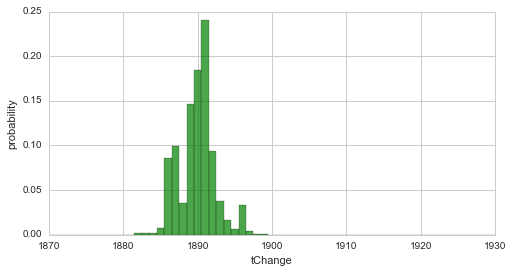

-----

Fit with custom normal prior:
+ Transition model: Change-point. Hyper-Parameter(s): ['tChange']
+ Detected 1 change-point(s) in transition model: ['tChange']
+ Set hyper-prior(s): ['sqrt(2)*exp(-(x - 1920)**2/50)/(10*sqrt(pi))']
+ Started new fit.
    + 109 analyses to run.

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: -80.50692
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


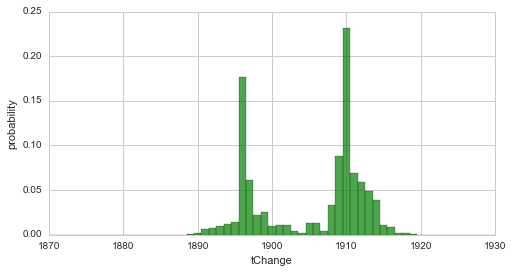

In [5]:
print 'Fit with flat hyper-prior:'
S = bl.ChangepointStudy()
S.loadExampleData()

L = bl.om.Poisson('accident_rate', bl.oint(0, 6, 1000))
T = bl.tm.ChangePoint('tChange', 'all')

S.set(L, T)
S.fit()

plt.figure(figsize=(8,4))
S.plot('tChange', facecolor='g', alpha=0.7)
plt.xlim([1870, 1930])
plt.show()
print('-----\n')
                      
print 'Fit with custom normal prior:'
T = bl.tm.ChangePoint('tChange', 'all', prior=sympy.stats.Normal('norm', 1920, 5))
S.set(T)
S.fit()

plt.figure(figsize=(8,4))
S.plot('tChange', facecolor='g', alpha=0.7)
plt.xlim([1870, 1930]);

Since we used a quite narrow prior (containing a lot of information) in the second case, the resulting distribution is strongly shifted towards the prior. The following example revisits the two break-point-model from [here](changepointstudy.html#Analyzing-structural-breaks-in-time-series-models) and a linear decrease with a varying slope as a hyper-parameter. Here, we define a Gaussian prior for the slope hyper-parameter, which is centered around the value -0.2 with a standard deviation of 0.4, via a lambda-function. For simplification, we set the break-points to fixed years.

In [6]:
S = bl.HyperStudy()
S.loadExampleData()

L = bl.om.Poisson('accident_rate', bl.oint(0, 6, 1000))
T = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                bl.tm.BreakPoint('t_1', 1880),
                                bl.tm.Deterministic(lambda t, slope=np.linspace(-2.0, 0.0, 30): t*slope, 
                                                    target='accident_rate',
                                                    prior=lambda slope: np.exp(-0.5*((slope + 0.2)/(2*0.4))**2)/0.4),
                                bl.tm.BreakPoint('t_2', 1900),
                                bl.tm.Static()
                                )

S.set(L, T)
S.fit()

+ Created new study.
  --> Hyper-study
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Transition model: Serial transition model. Hyper-Parameter(s): ['slope', 't_1', 't_2']
+ Set hyper-prior(s): ['<lambda> (re-normalized)', 'uniform', 'uniform']
+ Started new fit.
    + 30 analyses to run.

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: -74.84129
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


Finally, note that you can mix SymPy- and function-based hyper-priors for nested transition models.